In [1]:
# !git clone https://github.com/felixykliu/NAOMI.git

In [1]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("서인천IC-부평IC 평균속도.csv", encoding='CP949')
min_max_scaler = MinMaxScaler()
data["평균속도"] = min_max_scaler.fit_transform(data)[:,2]

data = data["평균속도"].to_numpy()
data[:10]

array([0.92784515, 0.95112091, 0.94291314, 0.93654294, 0.86671567,
       0.87014578, 0.84392993, 0.82910695, 0.78574054, 0.72105843])

In [3]:
data_batch = []

for i in range(0,200):
    data_batch.append(data[i:i+100])

for i in range(400, 644):
    data_batch.append(data[i:i+100])

data_batch = np.array(data_batch)
data_batch = data_batch.reshape(data_batch.shape[0], data_batch.shape[1], 1)
data_batch.shape

(444, 100, 1)

In [4]:
import argparse
import os
import math
import sys
import pickle
import time
import numpy as np
import shutil

from model import *
from torch.autograd import Variable
from torch import nn
import torch
import torch.utils
import torch.utils.data

from helpers import *

In [5]:
pretrain_epochs = 250
clip = 10
start_lr = 1e-3
batch_size = 64
save_every = 50


In [29]:
np.random.seed(123)
torch.manual_seed(123)
#if use_gpu:
#    torch.cuda.manual_seed_all(123)

params = {
    'task' : "--",
    'batch' : batch_size,
    'y_dim' : 1,
    'rnn_dim' : 50,
    'dec1_dim' : 30,
    'dec2_dim' : 30,
    'dec4_dim' : 30,
    'dec8_dim' : 30,
    'dec16_dim' : 30,
    'n_layers' : 2,
    'discrim_rnn_dim' : 128,
    'discrim_num_layers' : 1,
    'cuda' : False,
    'highest' : 8,
}

In [30]:
policy_net = NAOMI(params)
discrim_net = Discriminator(params)

#policy_net, discrim_net = policy_net.cuda(), discrim_net.cuda()
#policy_net, discrim_net = policy_net, discrim_net
params['total_params'] = num_trainable_params(policy_net)
train_data = torch.Tensor(data_batch)


In [31]:
best_test_loss = 0
lr = start_lr
teacher_forcing = True
for e in range(pretrain_epochs):
    
    epoch = e+1
    # control learning rate
    if epoch == pretrain_epochs // 2:
        lr = lr / 10
        print(lr)

    # train
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, policy_net.parameters()),
        lr=lr)

    start_time = time.time()
    clear_output(True)

    
    train_loss = run_epoch(True, policy_net, train_data, clip, optimizer, batch_size = batch_size, teacher_forcing=teacher_forcing)
    print('Train:\t' + str(train_loss)) 

    epoch_time = time.time() - start_time
    print('Time:\t {:.3f}'.format(epoch_time))

    print("Epoch: {}".format(epoch))

Train:	0.029092023
Time:	 2.844
Epoch: 250


In [32]:
filename = "model/model_pretrain.pth"
torch.save(policy_net.state_dict(), filename)


In [11]:
# filename = "model/model_pretrain.pth"
# policy_state_dict = torch.load(filename)
# policy_net.load_state_dict(policy_state_dict)

In [33]:
test = data.copy()
test[300:400] = 0
test = test.reshape(744,1,1)

#test = Variable(torch.Tensor(test).cuda())
test = Variable(torch.Tensor(test))


In [34]:
missing_list = range(300,400)
has_value = Variable(torch.ones(test.shape[0], test.shape[1], 1))
has_value[missing_list] = 0.0
if use_gpu:
    has_value = has_value.cuda()
has_value[missing_list] = 0.0

data_test = torch.cat([has_value, test], 2)

In [35]:
data_test.shape

torch.Size([744, 1, 2])

In [36]:
def predict_result(data_test):
    data_list = []
    for j in range(744):
        data_list.append(data_test[j:j+1])
    samples = policy_net.sample(data_list,1)
    result = samples[:,0,0].cpu().detach().numpy()
    return result

In [37]:
result = predict_result(data_test)

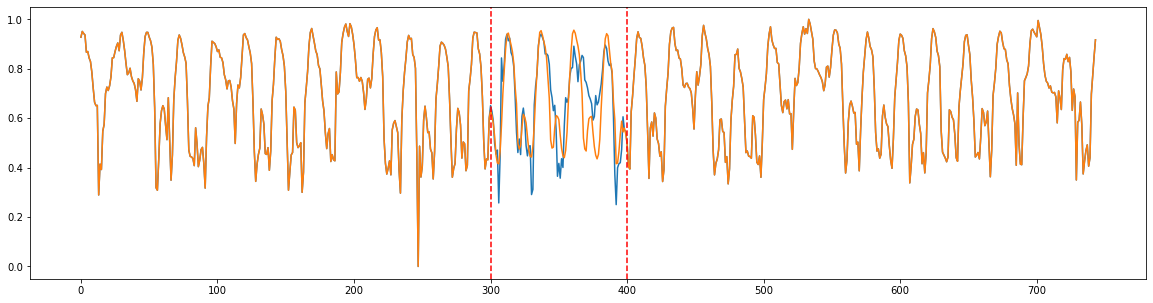

In [38]:
plt.figure(figsize=(20,5))
plt.plot(data)
plt.plot(result)
plt.axvline(x=300, color='r',linestyle='--')
plt.axvline(x=400, color='r',linestyle='--')
plt.show()


In [39]:
policy_learning_rate = 1e-3
discrim_learning_rate = 3e-6
# optimizer
optimizer_policy = torch.optim.Adam(
    filter(lambda p: p.requires_grad, policy_net.parameters()),
    lr=policy_learning_rate)
optimizer_discrim = torch.optim.Adam(discrim_net.parameters(), lr=discrim_learning_rate)
discrim_criterion = nn.BCELoss()
if use_gpu:
    discrim_criterion = discrim_criterion.cuda()

# stats
exp_p = []
win_exp_p = None
mod_p = []
win_mod_p = None
win_path_length = None
win_out_of_bound = None
win_step_change = None

In [40]:
train_data.shape

torch.Size([444, 100, 1])

In [41]:
pretrain_disc_iter = 2000 

# Pretrain Discriminator
for i in range(pretrain_disc_iter):
    exp_states, exp_actions, exp_seq, model_states_var, model_actions_var, model_seq, mod_stats, exp_stats = \
        collect_samples_interpolate(policy_net, train_data, use_gpu, i, "task", size = batch_size, name="pretraining", draw=False, stats=False)
    model_states = model_states_var.data
    model_actions = model_actions_var.data
    pre_mod_p, pre_exp_p = update_discrim(discrim_net, optimizer_discrim, discrim_criterion, exp_states, \
        exp_actions, model_states, model_actions, i, dis_times=3.0, use_gpu=use_gpu, train=True)

    clear_output(True)
    print(i, 'exp: ', pre_exp_p, 'mod: ', pre_mod_p)
    
    if pre_mod_p < 0.3:
        break

1999 exp:  tensor(0.5195) mod:  tensor(0.5059)


In [44]:
# GAN training
log_interval = 5
max_iter_num = 10000
for i_iter in range(max_iter_num):
    ts0 = time.time()
    # print("Collecting Data")
    exp_states, exp_actions, exp_seq, model_states_var, model_actions_var, model_seq, mod_stats, exp_stats = \
        collect_samples_interpolate(policy_net, train_data, use_gpu, i_iter, "task", size = batch_size, draw=False, stats=False)
#    exp_states, exp_actions, exp_seq, model_states_var, model_actions_var, model_seq, mod_stats, exp_stats = \
#        collect_samples_interpolate(policy_net, train_data, i_iter, "task", size = batch_size, draw=False, stats=False)
    model_states = model_states_var.data
    model_actions = model_actions_var.data
    
        
    ts1 = time.time()

    t0 = time.time()
    # update discriminator
    mod_p_epoch, exp_p_epoch = update_discrim(discrim_net, optimizer_discrim, discrim_criterion, exp_states, exp_actions, \
                                              model_states, model_actions, i_iter, dis_times=3.0, use_gpu=use_gpu, train=True)
#    mod_p_epoch, exp_p_epoch = update_discrim(discrim_net, optimizer_discrim, discrim_criterion, exp_states, exp_actions, \
#                                              model_states, model_actions, i_iter, dis_times=3.0, train=True)
    exp_p.append(exp_p_epoch)
    mod_p.append(mod_p_epoch)
    
    # update policy network
    if i_iter > 3 and mod_p[-1] < 0.8:
        update_policy(policy_net, optimizer_policy, discrim_net, discrim_criterion, model_states_var, model_actions_var, i_iter, use_gpu)
    t1 = time.time()

    if i_iter % log_interval == 0:
        clear_output(True)
        print('{}\tT_sample {:.4f}\tT_update {:.4f}\texp_p {:.3f}\tmod_p {:.3f}'.format(
            i_iter, ts1-ts0, t1-t0, exp_p[-1], mod_p[-1]))

8145	T_sample 0.2145	T_update 1.1523	exp_p 0.501	mod_p 0.499


KeyboardInterrupt: 

In [ ]:
filename_naomi = "model/model_naomi.pth"
filename_discrim = "model/model_discrim.pth"

torch.save(policy_net.state_dict(), filename_naomi)
torch.save(discrim_net.state_dict(), filename_discrim)

In [ ]:
result = predict_result(data_test)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data)
plt.plot(result)
plt.axvline(x=300, color='r',linestyle='--')
plt.axvline(x=400, color='r',linestyle='--')
plt.show()